In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Load and Preprocess Data

In [7]:
#Load Dataset
df = pd.read_excel("xeqt_historical.xlsx", sheet_name="Sheet1")
#Ensure Sorting By Date
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").set_index("Date")

In [8]:
#Data Sanity Check
required_cols = ["Open", "High", "Low", "Close", "Volume"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df = df[required_cols].dropna().copy()

In [11]:
#Defining Prediction Target to Prevent Information Leakage
df["Target_Close"] = df["Close"].shift(-1)
df = df.dropna().copy()
# Features available at end of day to predict Close on the next day
X = df[["Open", "High", "Low", "Close", "Volume"]].values
y = df["Target_Close"].values

## Split Data For Testing

In [12]:
#Split Data Chronologically
split = int(0.8 * len(df))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
test_dates = df.index[split:]

In [13]:
#Standardization and Ridge Regression
model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("reg", Ridge(alpha=1.0))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Evaluating Results

In [15]:
#Evaluating Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Evaluation on chronological test set:")
print(f"  RMSE: {rmse:.6f}")
print(f"  MAE : {mae:.6f}")
print(f"  R²  : {r2:.6f}")

Evaluation on chronological test set:
  RMSE: 0.312880
  MAE : 0.209713
  R²  : 0.968181


In [16]:
#Results Table
results = pd.DataFrame({
    "Actual_Close_t+1": y_test,
    "Pred_Close_t+1": y_pred
}, index=test_dates)

print("\nHead of prediction results:")
print(results.head(20))


Head of prediction results:
            Actual_Close_t+1  Pred_Close_t+1
Date                                        
2024-07-16             31.68       31.926918
2024-07-17             31.47       31.714779
2024-07-18             31.29       31.501678
2024-07-19             31.67       31.330005
2024-07-22             31.60       31.635018
2024-07-23             31.20       31.636279
2024-07-24             31.09       31.272534
2024-07-25             31.46       31.129042
2024-07-26             31.42       31.441255
2024-07-29             31.40       31.425149
2024-07-30             31.75       31.403926
2024-07-31             31.29       31.771349
2024-08-01             30.66       31.343998
2024-08-02             29.99       30.754540
2024-08-06             29.83       30.139332
2024-08-07             30.42       29.941141
2024-08-08             30.53       30.348811
2024-08-09             30.55       30.494139
2024-08-12             30.96       30.556046
2024-08-13             31.

## Plots and Visuals

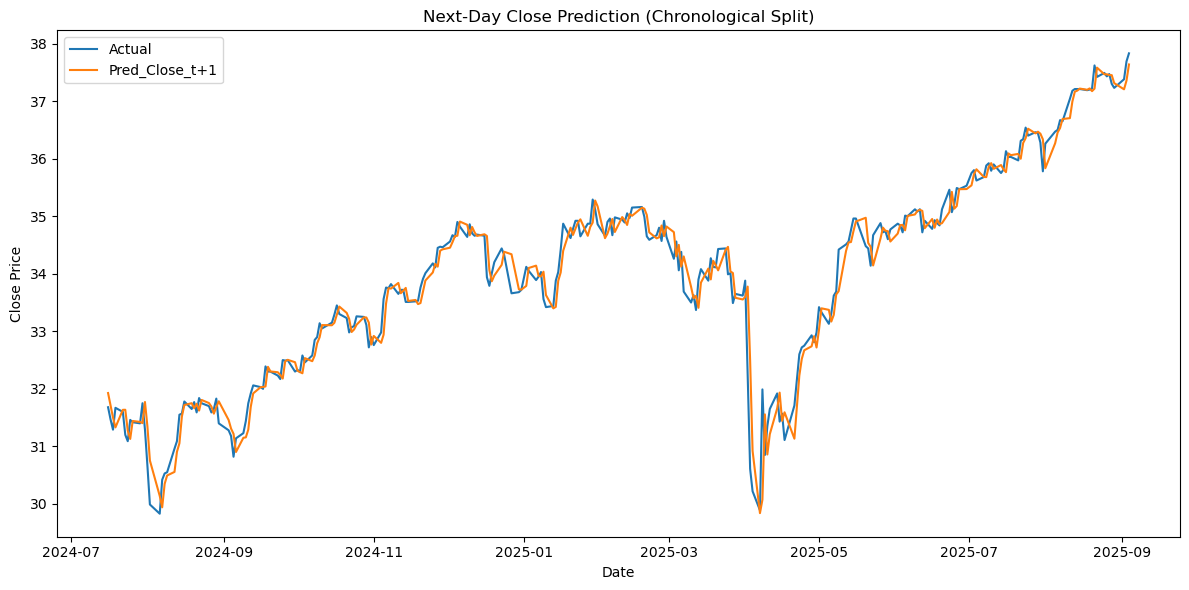

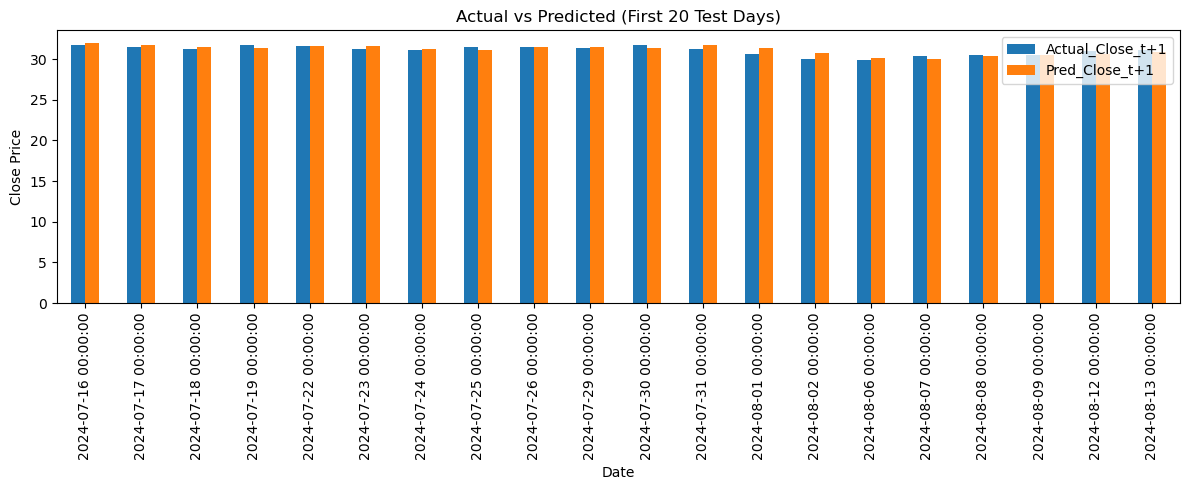

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(results.index, results["Actual_Close_t+1"], label="Actual")
plt.plot(results.index, results["Pred_Close_t+1"], label="Pred_Close_t+1")
plt.title("Next-Day Close Prediction (Chronological Split)")
plt.ylabel("Close Price")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

results.head(20).plot(kind="bar", figsize=(12, 5))
plt.title("Actual vs Predicted (First 20 Test Days)")
plt.ylabel("Close Price")
plt.xlabel("Date")
plt.tight_layout()
plt.show()